In [1]:
print("Metadata Project")

Metadata Project


In [2]:
import pandas as pd
filename = r'C:\Users\zissis\Downloads\metadata.csv'
Df = pd.read_csv(filename,sep=';') 
Df = Df.drop(columns=['Filename','StudyDate','Subject','StudyId','Columns','Rows'])
Df.dropna()

,Modality,Manufacturer,PhotometricInterpretation,BrixiaScore,BrixiaScoreGlobal,ConsensusTestset,Sex,AgeAtStudyDateFiveYear
0,CR,SIEMENS,MONOCHROME2,1,1,1,M,11
1,CR,Agfa,MONOCHROME1,2,2,1,M,8
2,CR,SIEMENS,MONOCHROME2,10,1,1,M,11
3,DX,CARESTREAM HEALTH,MONOCHROME1,21,3,1,M,12
4,DX,CARESTREAM HEALTH,MONOCHROME1,1001,2,1,M,8
...,...,...,...,...,...,...,...,...
4690,CR,SIEMENS,MONOCHROME2,1,1,0,M,10
4691,DX,CARESTREAM HEALTH,MONOCHROME1,122023,10,0,M,10
4692,CR,SIEMENS,MONOCHROME2,233133,15,0,M,14
4693,DX,CARESTREAM HEALTH,MONOCHROME1,333133,16,0,M,14


In [3]:
print(Df.tail(10))

     Modality       Manufacturer PhotometricInterpretation  BrixiaScore  \
4685       CR            SIEMENS               MONOCHROME2       333333   
4686       CR            SIEMENS               MONOCHROME2       333333   
4687       CR            SIEMENS               MONOCHROME2       333333   
4688       CR            SIEMENS               MONOCHROME2       333333   
4689       CR            SIEMENS               MONOCHROME2       333333   
4690       CR            SIEMENS               MONOCHROME2            1   
4691       DX  CARESTREAM HEALTH               MONOCHROME1       122023   
4692       CR            SIEMENS               MONOCHROME2       233133   
4693       DX  CARESTREAM HEALTH               MONOCHROME1       333133   
4694       DX  CARESTREAM HEALTH               MONOCHROME1       333133   

      BrixiaScoreGlobal  ConsensusTestset Sex  AgeAtStudyDateFiveYear  
4685                 18                 0   F                      15  
4686                 18       

In [4]:
Df_train = Df.sample(frac = 0.7, random_state=0)
Df_valid = Df.drop(Df_train.index)
X_train = Df_train.drop(columns='BrixiaScoreGlobal')
X_valid = Df_valid.drop(columns='BrixiaScoreGlobal')
Y_train = Df_train['BrixiaScoreGlobal']
Y_valid = Df_valid['BrixiaScoreGlobal']

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit
features_num = ['BrixiaScore','ConsensusTestset','AgeAtStudyDateFiveYear']
features_cat = ['Sex','Manufacturer','Modality','PhotometricInterpretation']
preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
Y_train = tf.convert_to_tensor(Y_train)
Y_valid = tf.convert_to_tensor(Y_valid)
input_shape = [X_train.shape[1]]
print(input_shape)


[18]


Minimum Validation Loss: 2.10516906


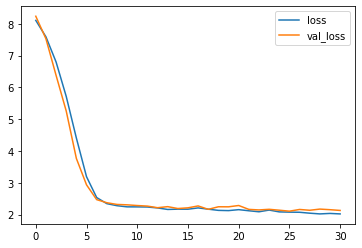

In [6]:
model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='selu'),
    layers.BatchNormalization(),
    layers.Dense(1)
])

stop = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, 
    restore_best_weights=True,
)

model.compile(
    optimizer='adam',
    loss='mae',
)
final = model.fit(
    X_train, Y_train,
    validation_data=(X_valid, Y_valid),
    batch_size=128,
    epochs=600,
    verbose=0,
    callbacks=[stop]
    
)
final_df = pd.DataFrame(final.history)
final_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.8f}".format(final_df['val_loss'].min()));